In [53]:
import torchvision
import torch
from pycocotools.coco import COCO
import cv2
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import utils_coco

In [12]:
# download or load the model from disk
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True) #Quizas añadir un min_size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the model onto the computation device
model.eval().to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [13]:
# get all images containing given categories
coco = COCO('dataset/instances_train2017.json')
 
categories_train = utils_coco.get_train_categories()
catIds = coco.getCatIds(catNms=categories_train)

imgIds = []
for cat in catIds:
    imgIds += coco.getImgIds(catIds=cat)
    
annIds = coco.getAnnIds(imgIds=imgIds, catIds=catIds, iscrowd=None)
imgsAnns = coco.loadAnns(annIds)
imgsInfo = coco.loadImgs(imgIds)

imgsInfo = sorted(imgsInfo, key=lambda x: x["id"])
imgsAnns = sorted(imgsAnns, key=lambda x: x["image_id"])

loading annotations into memory...
Done (t=11.24s)
creating index...
index created!


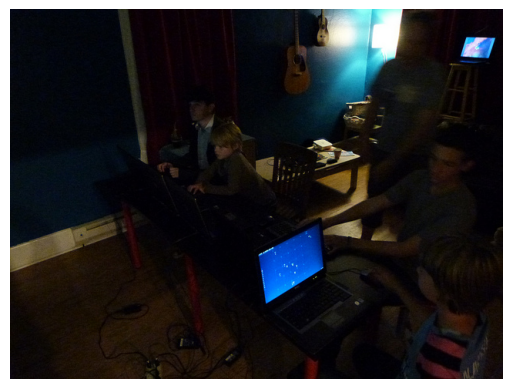

In [26]:
image_info = imgsInfo[2]
image = io.imread(image_info['coco_url'])
plt.axis('off')
plt.imshow(image)
# a NumPy copy for OpenCV functions
image_array = np.array(image)
# convert to OpenCV BGR color format
image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

In [27]:
    
COLORS = np.random.uniform(0, 255, size=(len(categories_train), 3))

transform = transforms.Compose([
    transforms.ToTensor(),
])

coco_names_all = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

coco_names = utils_coco.get_train_categories()

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    with torch.no_grad():
        outputs = model(image) # get the predictions on the image
        
    filtered_cats_indices = [outputs[0]['labels'].detach().cpu().numpy().index(i) for i in outputs[0]['labels'] if i in coco_names]
    
    labels = list(outputs[0]['labels'].detach().cpu().numpy())
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    labels_filtered = list()
    scores_filtered = list()
    bboxes_filtered = list()
    
    for i in range(len(labels)):
        if coco_names_all[labels[i]] in coco_names:
            labels_filtered.append(labels[i])
            scores_filtered.append(scores[i])
            bboxes_filtered.append(bboxes[i])
    
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores_filtered.index(i) for i in scores_filtered if i > detection_threshold]
    # get boxes above the threshold score
    boxes = np.array(bboxes_filtered)[np.array(scores_filtered) >= detection_threshold].astype(np.int32)
    # get all the predicited class names
    pred_classes = [coco_names_all[labels_filtered[i]] for i in thresholded_preds_inidices]
    return boxes, pred_classes

[[316 269 467 461]]
['laptop']


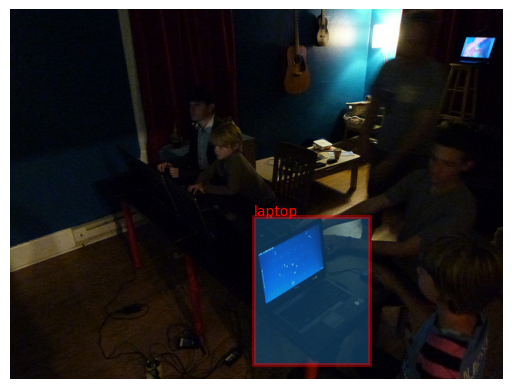

In [29]:
# get the bounding boxes and class labels
boxes, classes = predict(image, model, device, 0.7)
print(boxes)
for box in boxes:
    box[2]-=box[0]
    box[3]-=box[1]
print(classes)
# get the final image
result = utils_coco.draw_boxes(image_info, boxes, classes)

In [17]:
# get all images containing given categories
coco_val = COCO('dataset/instances_val2017.json')
 
categories_train = utils_coco.get_train_categories()
catIds = coco_val.getCatIds(catNms=categories_train)

imgIds_val = []
for cat in catIds:
    imgIds_val += coco_val.getImgIds(catIds=cat)
    
annIds_val = coco_val.getAnnIds(imgIds=imgIds_val, catIds=catIds, iscrowd=None)
imgsAnns_val = coco_val.loadAnns(annIds_val)
imgsInfo_val = coco_val.loadImgs(imgIds_val)

imgsInfo_val = sorted(imgsInfo_val, key=lambda x: x["id"])
imgsAnns_val = sorted(imgsAnns_val, key=lambda x: x["image_id"])

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


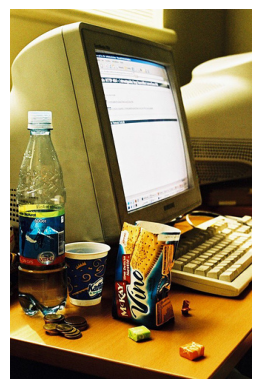

In [45]:
image_info = imgsInfo[5]
image = io.imread(image_info['coco_url'])
plt.axis('off')
plt.imshow(image)
# a NumPy copy for OpenCV functions
image_array = np.array(image)
# convert to OpenCV BGR color format
image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

In [48]:
image_info


{'license': 1,
 'file_name': '000000000909.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000000909.jpg',
 'height': 500,
 'width': 327,
 'date_captured': '2013-11-22 00:37:54',
 'flickr_url': 'http://farm1.staticflickr.com/80/260341952_1ce1f18023_z.jpg',
 'id': 909}

[[217 271 326 386]]
['keyboard']


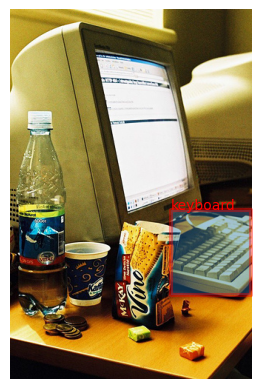

In [46]:
# get the bounding boxes and class labels
boxes, classes = predict(image, model, device, 0.6)
print(boxes)
for box in boxes:
    box[2]-=box[0]
    box[3]-=box[1]
print(classes)
# get the final image
result = utils_coco.draw_boxes(image_info, boxes, classes)

In [47]:
def intersection_over_union(gt, pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [ ]:
intersection_over_union(